<a href="https://colab.research.google.com/github/Karanjit75/Smart-Garbage-Sorting-System/blob/main/Project%20Code%20File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **APS360 - Smart Garbage Sorting System**

Karanjit Gandhi
(1008241207)


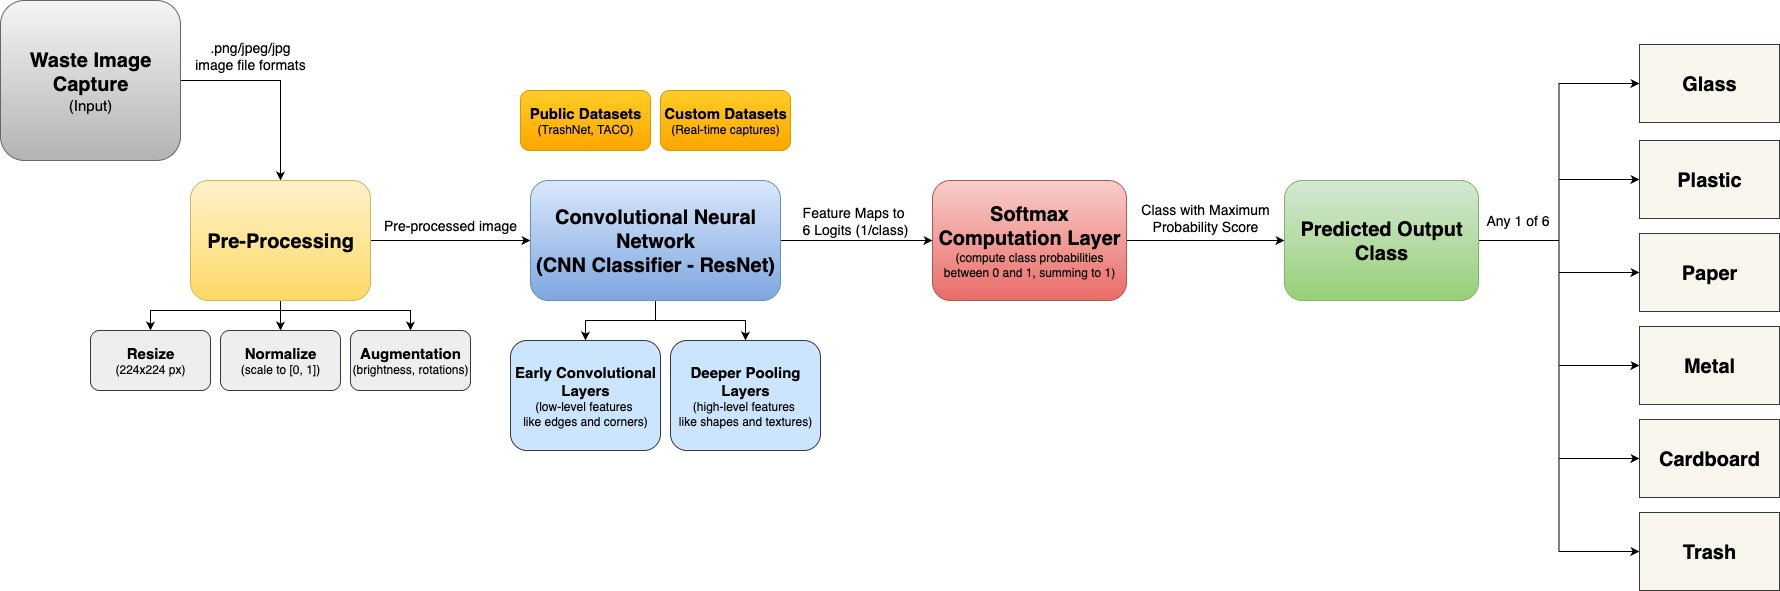
---






---



# **Data Processing**
*   Consolidation of images/dataset (with reproducibility, corruption and empty folder checks)
*   Data Pre-processing (Normalization Statistics & Data Augmentation)
*   Data Splitting (training/validation/testing)
*   Printing cleaned images


### **Import Relevant Libraries:**

In [9]:
#Import Relevant Libraries
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import os
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import random
import shutil

### **Run GPU (if available):**

In [2]:
# Run GPU if available for faster runtime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


### **Random Seed for Reproducibility:**

In [3]:
# Reproducibility (set random seed)
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

set_seed(42)

### **Mount Google Drive in Colab:**

In [4]:
# Mount Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Dataset Directory:**

In [6]:
# Get data directory for combined dataset (TrashNet + self-collected images)
data_path = "/content/drive/MyDrive/4th Year/4F/APS360 - Machine Learning/Project/Progress Report/Project Dataset"
print(sorted(os.listdir(data_path)))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### **User Paths:**

In [8]:
# Current combined dataset with class folders only
source_dir = Path("/content/drive/MyDrive/4th Year/4F/APS360 - Machine Learning/Project/Progress Report/Project Dataset")

# Where the split folders (train/val/test) will be created
target_dir = Path("/content/drive/MyDrive/4th Year/4F/APS360 - Machine Learning/Project/Progress Report/Split Dataset")

# Where the figures/logs will be saved for the report
out_dir = Path("/content/drive/MyDrive/4th Year/4F/APS360 - Machine Learning/Project/Progress Report/Figures and Logs")
out_dir.mkdir(parents=True, exist_ok=True)

print("Source Directory:", source_dir)
print("Target Directory:", target_dir)
print("Output Directory:", out_dir)

Source Directory: /content/drive/MyDrive/4th Year/4F/APS360 - Machine Learning/Project/Progress Report/Project Dataset
Target Directory: /content/drive/MyDrive/4th Year/4F/APS360 - Machine Learning/Project/Progress Report/Split Dataset
Output Directory: /content/drive/MyDrive/4th Year/4F/APS360 - Machine Learning/Project/Progress Report/Figures and Logs


### **Split Folder Creation (Train/Val/Test):**

In [11]:
# Create train/val/test split with 70/15/15 ratio
ratios = {"train": 0.70, "val": 0.15, "test": 0.15}
class_folders = [d for d in sorted(os.listdir(source_dir)) if (source_dir/d).is_dir()]

# Build folder structure
for split in ratios.keys():
  for cls in class_folders:
    (target_dir/split/cls).mkdir(parents=True, exist_ok=True)

# Populate split if empty
def is_empty_split(target_root):
  for split in ratios.keys():
    for cls in class_folders:
      if any((target_root/split/cls).glob("*")):
        return False
  return True

if is_empty_split(target_dir):
  print("Creating split folders...")
  random.seed(42)
  for cls in class_folders:
    cls_dir = source_dir/cls
    imgs = [p for p in cls_dir.glob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
    random.shuffle(imgs)

    n = len(imgs)
    n_train = int(ratios["train"]*n)
    n_val = int(ratios["val"]*n)
    mapping = {
        "train": imgs[:n_train],
        "val": imgs[n_train:n_train+n_val],
        "test": imgs[n_train+n_val:]
    }

    for split, paths in mapping.items():
      for p in paths:
        dest = target_dir/split/cls/p.name
        if not dest.exists():
          shutil.copy(p, dest)
  print("Split created at:", target_dir)
else:
  print("Split already exists at:", target_dir)

Creating split folders...
Split created at: /content/drive/MyDrive/4th Year/4F/APS360 - Machine Learning/Project/Progress Report/Split Dataset


In [12]:
# List corrupted files
def valid_image(path):
  try:
    with Image.open(path) as img:
      img.load()
    return True
  except (UnidentifiedImageError, OSError, ValueError):
    return False

bad = []
for split in ['train', 'val', 'test']:
  for cls in class_folders:
    for p in (target_dir/split/cls).glob("*"):
      if p.suffix.lower() in {".jpg", ".jpeg", ".png"} and not valid_image(p):
        bad.append(str(p))

print("Number of corrupted images:", len(bad))
if bad:
  for b in bad[:12]:
    print(" -", b)

Number of corrupted images: 0


In [18]:
# Print counts per split and per class:
def count_images_in_folder(folder):
  cnt = 0
  for root, _, files in os.walk(folder):
    for f in files:
      if f.lower().endswith((".jpg", ".jpeg", ".png")):
        cnt += 1
  return cnt

grand_total = 0
for split in ["train", "val", "test"]:
  split_dir = target_dir/split
  print(f"Split: {split}")
  split_total = 0
  for cls in class_folders:
    n = count_images_in_folder(split_dir/cls)
    split_total += n
    print(f" {cls:<10}: {n}")
  grand_total += split_total
  print(f"\nTotal {split} images: {split_total}\n")
print(f"\nGrand Total: {grand_total} images")

Split: train
 cardboard : 285
 glass     : 354
 metal     : 290
 paper     : 419
 plastic   : 340
 trash     : 99

Total train images: 1787

Split: val
 cardboard : 61
 glass     : 75
 metal     : 62
 paper     : 89
 plastic   : 73
 trash     : 21

Total val images: 381

Split: test
 cardboard : 62
 glass     : 77
 metal     : 63
 paper     : 91
 plastic   : 74
 trash     : 22

Total test images: 389


Grand Total: 2557 images


In [22]:
from numpy._core.fromnumeric import mean
# Dataset Normalization

image_size = 224
tfm_for_stats = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()       # Values in [0,1]
])

ds_train_for_stats = datasets.ImageFolder(target_dir/"train", transform=tfm_for_stats)
dl_stats = torch.utils.data.DataLoader(ds_train_for_stats, batch_size=32, shuffle=False, num_workers=2)

mean = torch.zeros(3)
std = torch.zeros(3)
total = 0

for imgs, _ in dl_stats:  #imgs: [B,3,H,W] in [0,1]
  b = imgs.size(0)
  imgs = imgs.view(b, 3, -1)            # [B,3,H*W]
  mean += imgs.mean(dim=2).sum(dim=0)   # sum image means
  std += imgs.std(dim=2).sum(dim=0)     # sum image std devs.
  total += b

mean /= total
std /= total

image_mean = tuple(round(x, 3) for x in mean.tolist())
image_std = tuple(round(x, 3) for x in std.tolist())

print(f"Dataset Mean: {image_mean}")
print(f"Dataset Std Dev.: {image_std}")

Dataset Mean: (0.669, 0.635, 0.599)
Dataset Std Dev.: (0.182, 0.18, 0.19)


In [23]:
from torch.utils.data.dataloader import DataLoader
# Implementing normalization & data augmentation on training data to reduce risks of overfitting:
train_tfms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(0.5), # horizontal flip at probability p=0.5
    transforms.RandomRotation(10),        # rotate image by 10 degrees (small angle)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])

# Defining evaluation transforms (validation & testing)
eval_tfms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])

# Build data loaders for modeling
ds_train = datasets.ImageFolder(target_dir/"train", transform=train_tfms)
ds_val = datasets.ImageFolder(target_dir/"val", transform=eval_tfms)
ds_test = datasets.ImageFolder(target_dir/"test", transform=eval_tfms)

classes = ds_train.classes
num_classes = len(classes)
print("Classes:", classes)

dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=2)
dl_test = DataLoader(ds_test, batch_size=32, shuffle=False, num_workers=2)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


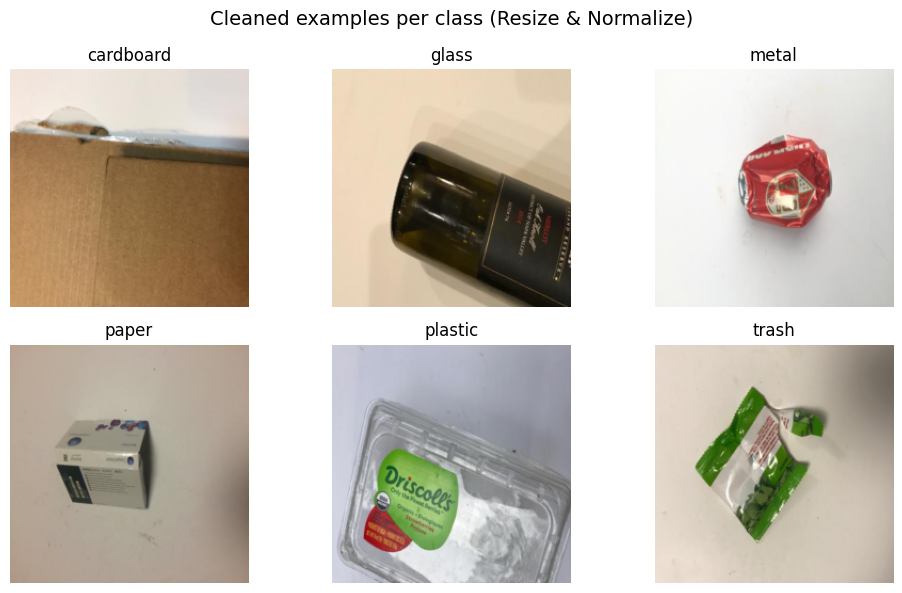

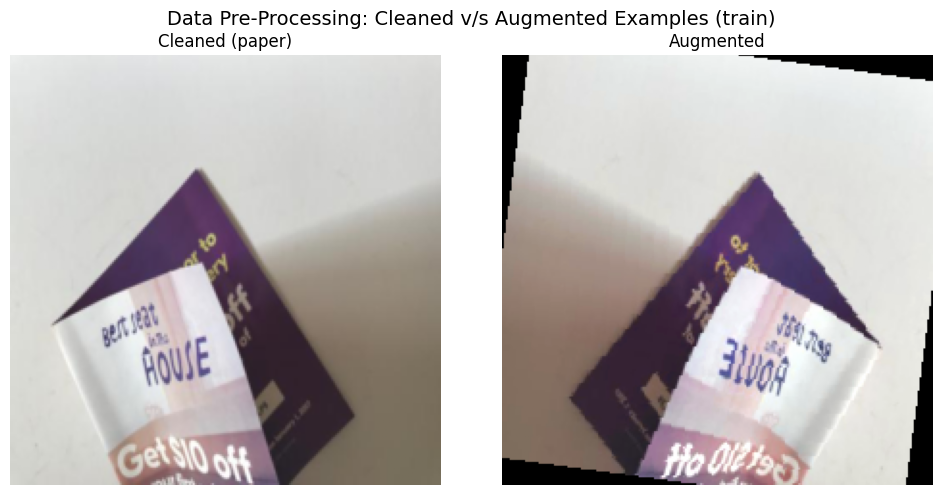

In [29]:
# Generating some visuals:

# One cleaned sample per class
inv_mean = torch.tensor(image_mean).view(3,1,1)
inv_std = torch.tensor(image_std).view(3,1,1)

def show_tensor_img(t):
  x = t.detach().cpu()*inv_std + inv_mean
  x = x.clamp(0,1)
  return x.permute(1,2,0).numpy()

val_samples = ds_val.samples
by_cls_val = {i: [] for i in range(num_classes)}
for index, (p, y) in enumerate(val_samples):
  by_cls_val[y].append(index)

fig, axs = plt.subplots(2,3,figsize=(10, 6))
axs = axs.flatten()
for i, c in enumerate(classes):
  if by_cls_val[i]: # prefer validation
    path, _ = ds_val.samples[random.choice(by_cls_val[i])]
    img = ds_val.loader(path)
    t = eval_tfms(img)
  else: # fallback to train
    paths = [p for p,y in ds_train.samples if y==i]
    path = random.choice(paths)
    img = ds_train.loader(path)
    t = eval_tfms(img)
  axs[i].imshow(show_tensor_img(t))
  axs[i].set_title(c)
  axs[i].axis('off')
plt.suptitle("Cleaned examples per class (Resize & Normalize)", fontsize=14)
plt.tight_layout()
plt.show()

# Cleaned v/s Augmented visuals
p, lbl = random.choice(ds_train.samples)
img = ds_train.loader(p)
t_clean = eval_tfms(img)
t_augmented = train_tfms(img)

fig, axs = plt.subplots(1,2,figsize=(10, 5))
axs[0].imshow(show_tensor_img(t_clean))
axs[0].set_title(f"Cleaned ({classes[lbl]})")
axs[0].axis('off')
axs[1].imshow(show_tensor_img(t_augmented))
axs[1].set_title("Augmented")
axs[1].axis('off')

plt.suptitle("Data Pre-Processing: Cleaned v/s Augmented Examples (train)", fontsize=14)
plt.tight_layout()
plt.show()